[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nils-holmberg/socs-qmd/blob/main/jnb/lab2_nlp2.ipynb)

# Natural Language Processing on the Israel and Palestine Conflict
By Minahil Malik

This lab report aims to analyze the topics and sentiments that arise in articles written by the Economist surrounding the Israel and Palestine conflict.

### Significance and Rationale
The Israel-Palestine Conflict, one of the most enduring conflicts in history, dates back to the start of the 20th century, with the establishment of the British Mandate in Palestine (Imtiaz et al. 2022). The conflict is intricately woven with complexities in political, demographic, and religious spheres (Imtiaz et al. 2022).  These deep-seated and multifaceted challenges present significant challenges to finding a resolution and contribute to its volatile nature, particularly in online discussions.
Online mass media (newspaper, radio, blogs) significantly influences public opinion on controversial events, notably in the Israeli-Palestinian conflict. Palestinians often perceive a bias in Western media coverage (Al-Sarraj and Lubbad, 2018: 98). Despite journalistic norms of objectivity, reports frequently embed personal opinions, intensifying debates about media objectivity in this conflict.
This study seeks to analyze the topics and sentiments presented by a major news outlet like ‘The Economist’, often considered 'objective', in the context of its reporting.

Online reporting with regards to the Israel and Palestine conflict is particularly important to understand the role of mass media in shaping public opinion and for comprehending the broader debate around such volatile issues.
Since media plays such a crucial role in constructing and disseminating political and religious narratives. Understanding these narratives and their framing is key to comprehending such a conflict and its complexities. The case of Israel and Palestine, while distinct, represents much more theoretically. It serves as a crucial case for understanding similar conflicts and power dynamics worldwide. The conflict's intersection with global issues such as colonialism, religious tensions, economic incentives, and geopolitical struggles makes it theoretically a very important case. Additionally, the findings offer the general public a more nuanced understanding of the conflict, contributing to the discourse on media ethics and journalistic practices.

### Method
This report employs content analysis, adhering to Neuendorf's definition of it as a “systematic, objective, and quantitative examination of message characteristics” (Neuendorf, 2017:  2). Specifically, this report concentrates on a computer-driven analysis within news media using topic modeling and sentiment analysis.


### Importing the Dataset
Web scraping of the economist website was done using the web_scraping.py file which can be found in the GitHub repo here: https://github.com/minahilm11/SIMM71. One search for Israel was done for 100 articles and one search for palestine for another 100. These searches mostly resulted in articles from 2023 so an aditional 10 articles from each year were added by searching for Israel + Palestine + {year} for the years 2011-2022. Searching in this way naturally results in some duplicates, the datasets were all merged into one with the duplicates removed using the combine_csv_without_duplicates.py file which can also be found in the GitHub repo. In total 251 unique articles were used.

In [5]:
#Importing packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from collections import Counter
import calendar
import nltk
from nltk import bigrams
from nltk.probability import FreqDist
from collections import Counter
import gensim
from gensim.models import LdaModel
from nltk.sentiment import SentimentIntensityAnalyzer

In [6]:
# Loading data set
#!pip install gdown
!gdown https://drive.google.com/uc?id=13R1hdrZ50FLFpPdF6h5fCRQ1Y61itqjn
fp = "economist_dataset.csv"
df = pd.read_csv(fp, header=0) # header=0 because in Python it starts from zero
print(df.shape)
df.head()
dates = []
years = []
for i in range(len(df)):
    date = "20"+df['link'][i].split("/20")[1][:8] # Manual Way to extract dates from The economist article links since we will need it later
    if len(date) != 10:
        date += "/20" # Previous code splits on both the year starting with 20 and the day which we don't want, this corrects that
    dates.append(date)
    years.append(date[:4])
df['date'] = dates
df['year'] = years

Downloading...
From: https://drive.google.com/uc?id=13R1hdrZ50FLFpPdF6h5fCRQ1Y61itqjn
To: /content/economist_dataset.csv
100% 1.51M/1.51M [00:00<00:00, 146MB/s]
(251, 2)


### Exploratory Data Analysis
#### Topic Modeling and Descriptives
For a comprehensive grasp of the Israel-Palestine issue, I will run some descriptive statistics to gain a general sense of the prevalent trends within the Economist articles. Additionally, a basic topic modeling exercise will be conducted. Although the topic modeling may give us limited information for this particular topic, it still serves as a crucial preliminary phase for comprehending the dataset before proceeding to conduct sentiment analysis.


954.6892430278884


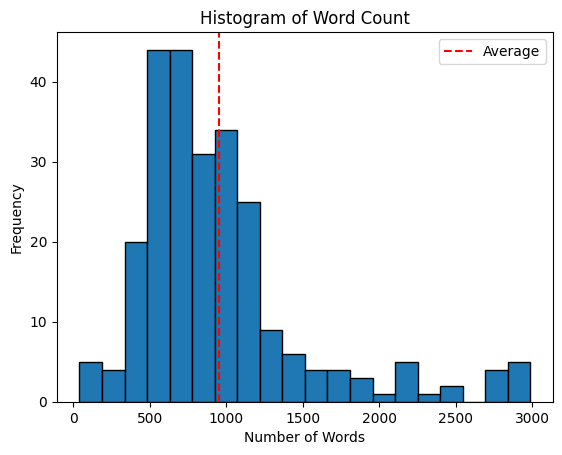

In [7]:
corpus = df['content'].tolist() # convert the content column into a list
split_corpus = [article.split() for article in corpus]

# Descriptive analysis
# Number of words in each article
word_count = [len(article) for article in split_corpus]
import matplotlib.pyplot as plt

plt.hist(word_count, bins=20, edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Word Count')

# Calculate the average number of words
avg_word_count = sum(word_count) / len(word_count)
print(avg_word_count)

# Visualisation that plots the average number of words as a vertical line
plt.axvline(x=avg_word_count, color='red', linestyle='--', label='Average')

plt.legend()
plt.show()


The average word count per article in The Economist was 955.

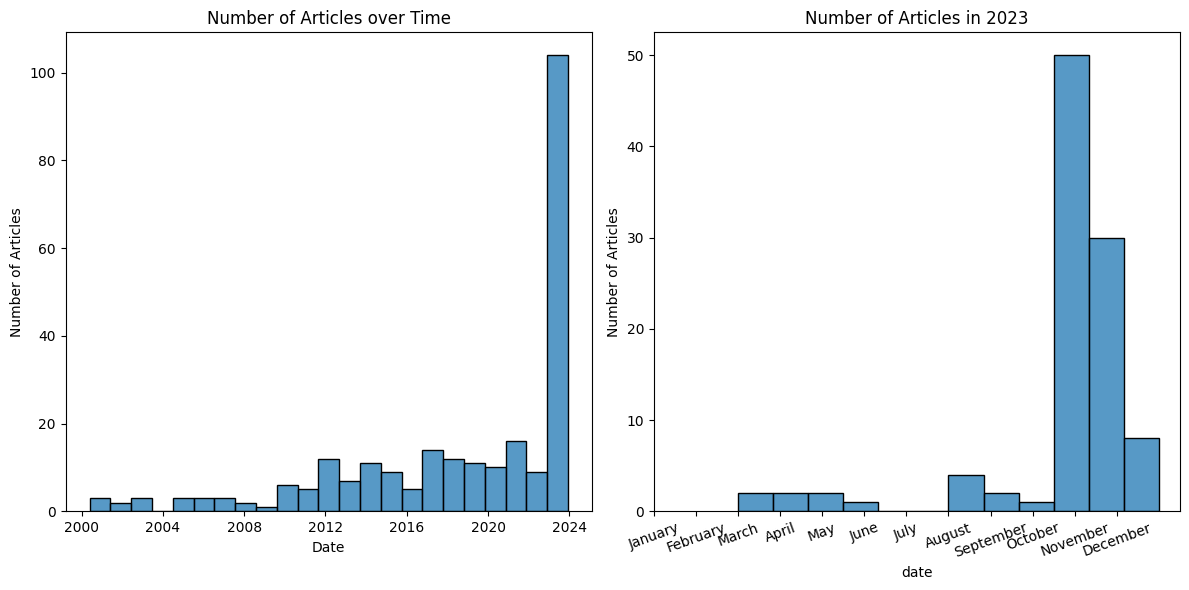

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plotting the number of articles over time
df['date'] = pd.to_datetime(df['date'])
sns.histplot(df['date'], bins=23, edgecolor='black', ax=axs[0])
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Number of Articles')
axs[0].set_title('Number of Articles over Time')

# Plotting the number of articles in 2023
this_year_df = df[df['date'] > '2023-01-01']
sns.histplot(this_year_df['date'].dt.month, bins=12, edgecolor='black', ax=axs[1])
axs[1].set_xticks(np.arange(12))
axs[1].set_xticklabels(calendar.month_name[1:13], rotation=20)
axs[1].set_ylabel('Number of Articles')
axs[1].set_title('Number of Articles in 2023')

plt.tight_layout()
plt.show()

I was interested in the temporal trend of articles published on the Palestine and Israel conflict given that it is an issue that dates back to 1947 and is not just an issue that has recently existed (despite the increase in media attention). The histogram showed an increase in article frequency, with a sudden increase in 2023. This is partly due to the way the economist search function works and partly because of the increase in media attention recently.

I also visualized the number of articles in 2023 per month. Further inspection of the 2023 data indicated that the highest number of articles appeared in October, followed by a significant quantity in November before decreasing in December. This is not surprising as there was a Hamas led attack on Israel on October the 7th which gained a lot of media attention. Hence, the results are in line with the theoretical expectations of this issue.

### Data Cleaning Function
We do not want to have every individual word fragment we have ever encountered in our vocabulary (Kedia & Rasu, 2020: 60). Hence, the data was cleaned by excluding stopwords, punctuation and reducing them to their base form (lemmatizing) for a better result from the topic modeling.

In [10]:
# Download necessary NLTK data
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

# defining data cleaning function
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
exclude.update("’","“","”","—") #taking out extra (weird) versions of punctuation that were still in the dataset even after removing punctuation
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch if ch not in exclude else "" for ch in stop_free)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

# clean data stored in a new list
clean_corpus = [clean(doc).split() for doc in corpus]
df['clean_content'] = clean_corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


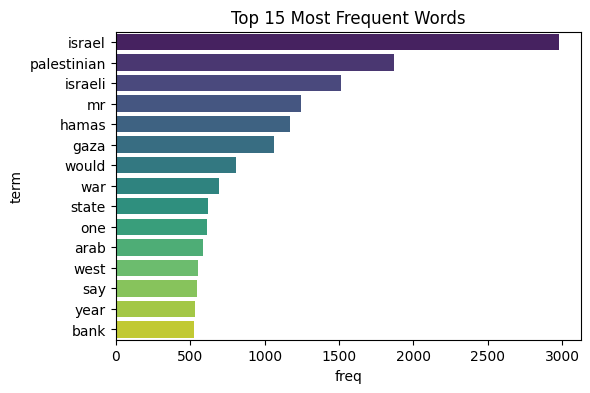

In [11]:
# Creating a frequency table for more descriptive analysis
word_freq = [article for article in clean_corpus]
word_freq = pd.Series(np.concatenate(word_freq)).value_counts()

# Converting the Series to a DataFrame
word_freq_df = word_freq.to_frame().reset_index()
word_freq_df.columns = ['term','freq']

# Plotting the top 15 words
top_n = 15
plt.figure(figsize=(6, 4))
sns.barplot(x='freq', y='term', data=word_freq_df.head(top_n), palette='viridis')

plt.title(f'Top {top_n} Most Frequent Words')
plt.xlabel('freq')
plt.ylabel('term')

plt.show()

Before conducting a sentiment analysis, I analyzed the top 15 words and bigrams as they can provide useful context about the data. The top words consist of "Israel" and "Palestinian," which are neutral by themselves and pertain to entities involved in the conflict and are thus not very surprising to see. The presence of words such as "war" may suggest that our sentiment analysis might categorize articles with negative sentiment due to the nature of the issue.

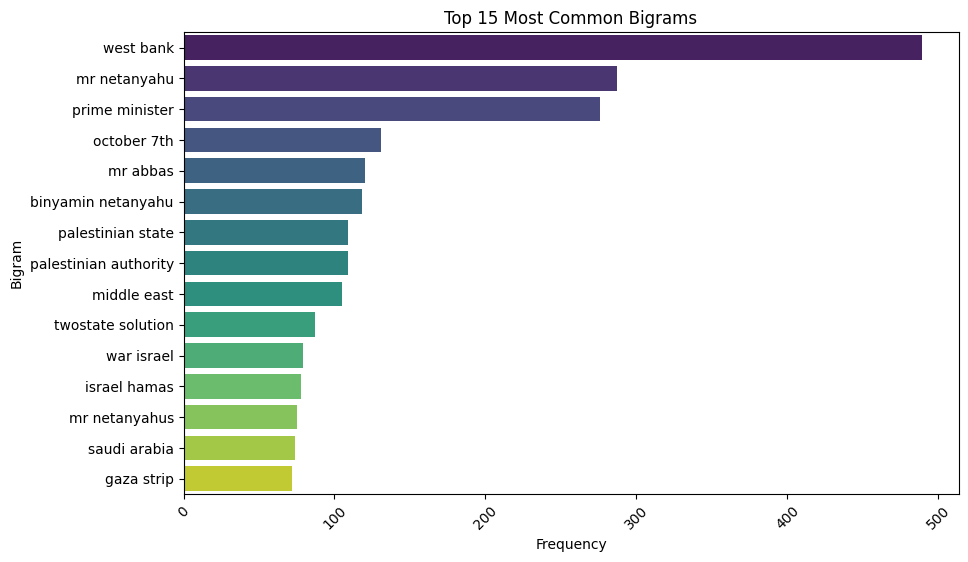

In [12]:
#bigram frequency histogram
combined_corpus = np.concatenate(clean_corpus)
# Create a list of all bigrams in the clean_corpus
all_bigrams = list(bigrams(combined_corpus))

# Calculate the frequency distribution of the bigrams
bigram_freq = FreqDist(all_bigrams)

# Get the most common bigrams
top_n = 15
most_common_bigrams = bigram_freq.most_common(top_n)
bigram_labels = [' '.join(bigram) for bigram, _ in most_common_bigrams]
frequencies = [freq for _, freq in most_common_bigrams]
data = pd.DataFrame({'Bigram': bigram_labels, 'Frequency': frequencies})

plt.figure(figsize=(10, 6))
sns.barplot(y='Bigram', x='Frequency', data=data, palette='viridis')
plt.title(f'Top {top_n} Most Common Bigrams')
plt.xticks(rotation=45)
plt.show()

Similarly, the most frequent bigram is "west bank," while "gaza strip" has the lowest frequency among the displayed bigrams, which is particularly interesting as these both refer to disputed territorial areas. The only distinction here is that the Gaza strip is controlled largely by Hamas whereas the west bank is divided between the Palestinians and Israeli authorities.


<ipython-input-13-9b38798849ef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2011['bigrams'] = df2011['clean_content'].apply(lambda x: list(bigrams(x)))


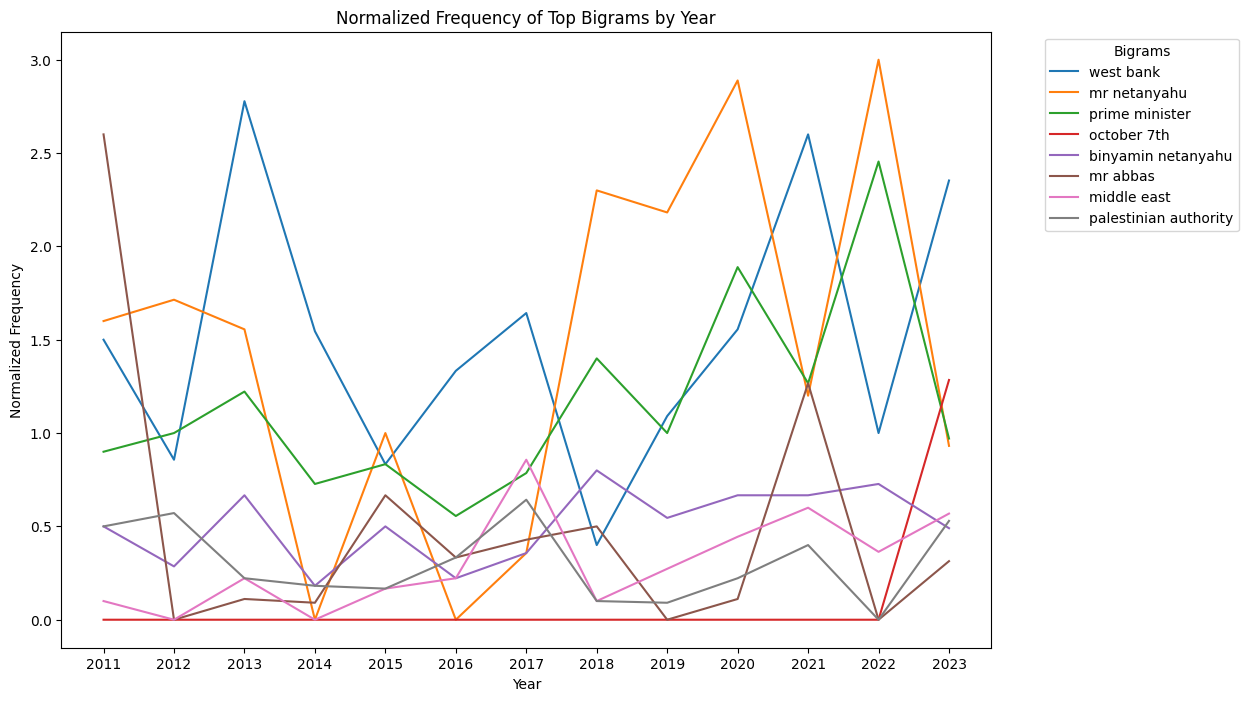

In [13]:
df2011 = df[df['year'] >='2011']
# Aggregate bigrams by year
df2011['bigrams'] = df2011['clean_content'].apply(lambda x: list(bigrams(x)))
all_bigrams = sum(df2011['bigrams'], [])

# Calculate the frequency distribution of all bigrams
bigram_freq = FreqDist(all_bigrams)
top_n = 8  # Number of top bigrams to track
most_common_bigrams = bigram_freq.most_common(top_n)
top_bigrams = [bigram for bigram, _ in most_common_bigrams]

# Track Frequency Over Time
# Aggregate bigrams by year
aggregate_bigrams_by_year = df2011.groupby('year')['bigrams'].sum()

# Initialize a DataFrame to store the frequency of top bigrams over time
bigram_freq_by_year = pd.DataFrame(0, index=[(' '.join(bigram)) for bigram in top_bigrams], columns=sorted(df2011['year'].unique()))

for year, bigrams in aggregate_bigrams_by_year.items():
    year_bigram_freq = FreqDist(bigrams)
    for bigram in top_bigrams:
        formatted_bigram = ' '.join(bigram)
        bigram_freq_by_year.at[formatted_bigram, year] = year_bigram_freq[bigram]

# Normalization
articles_per_year = df2011['year'].value_counts().sort_index()
bigram_freq_by_year = bigram_freq_by_year.apply(lambda x: x / articles_per_year, axis=1)

# Visualization
plt.figure(figsize=(12, 8))
for bigram in bigram_freq_by_year.index:
    plt.plot(bigram_freq_by_year.columns, bigram_freq_by_year.loc[bigram], label=bigram)

plt.xlabel('Year')
plt.ylabel('Normalized Frequency')
plt.title('Normalized Frequency of Top Bigrams by Year')
plt.legend(title="Bigrams", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



I delved deeper into the bigrams by plotting the occurrence of specific bigrams from 2011 to 2023 (there weren't enough articles for the years before 2011 in the dataset to perform a good analysis). These peaks in the graph could point to periods of heightened discussion based on certain bigrams that catalyzed public interest. Hence, were important to explore.
The graph shows that from 2022 to 2023, there is an increase in the normalized frequency of several bigrams associated with the Israel-Palestine conflict such as October 7th and the West Bank. Whereas discussions about Mr.Netanyahu and Mr.Prime Minister dropped drastically in the last year.

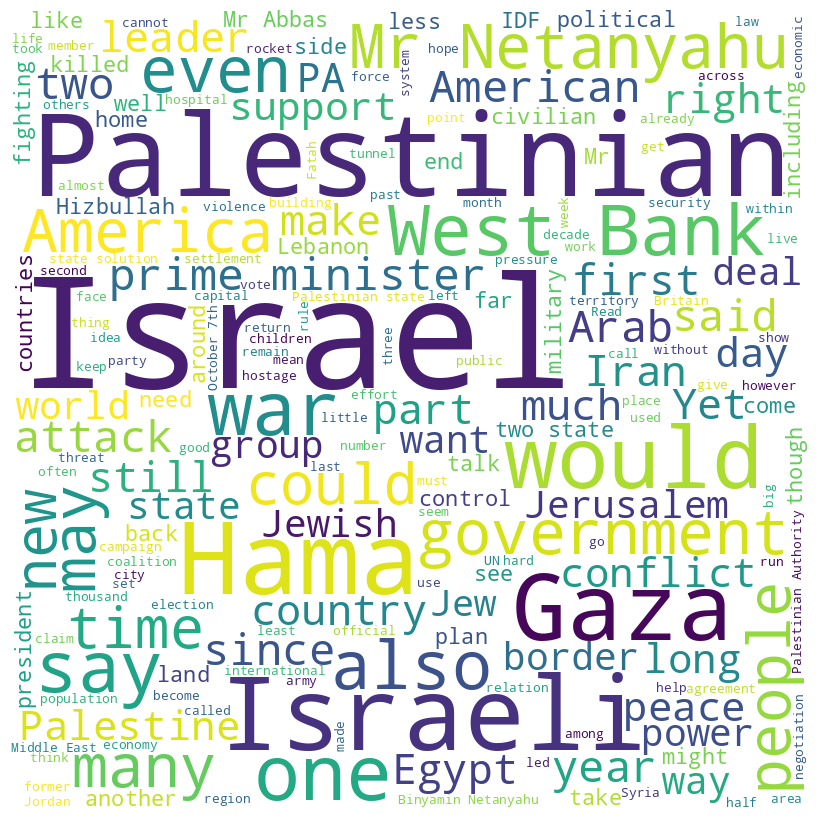

In [14]:
# Text Exploration - Word Cloud
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords.words('english'),
                min_font_size = 10).generate(" ".join(df['content']))

# Plot Word Cloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

### Tokenizing for descriptives
Tokenization is a segmentation technique wherein you are trying to break down larger pieces of text chunks into smaller meaningful ones (Kedia & Rasu, 2020: 52).Tokens typically include words, numbers, and sometimes punctuation, symbols, or clear emoticons  (Kedia & Rasu, 2020: 52).

In [15]:
# Load the spaCy model for sentence segmentation
import spacy
nlp = spacy.load("en_core_web_sm")

# Function to split text into sentences and create a new DataFrame
def split_sentences(df):
    sentence_data = {'id': [], 'sentence_number': [], 'sentence_text': []}

    for _, row in df.iterrows():
        doc = nlp(row['content'])
        for i, sentence in enumerate(doc.sents, start=1):
            sentence_data['id'].append(row['link'])
            sentence_data['sentence_number'].append(i)
            sentence_data['sentence_text'].append(sentence.text)

    return pd.DataFrame(sentence_data)

# Create a new DataFrame with sentences
sentences_df = split_sentences(df)

# Print the new DataFrame
print(sentences_df)


                                                      id  sentence_number  \
0      https://www.economist.com/middle-east-and-afri...                1   
1      https://www.economist.com/middle-east-and-afri...                2   
2      https://www.economist.com/middle-east-and-afri...                3   
3      https://www.economist.com/middle-east-and-afri...                4   
4      https://www.economist.com/middle-east-and-afri...                5   
...                                                  ...              ...   
13064  https://www.economist.com/middle-east-and-afri...               42   
13065  https://www.economist.com/middle-east-and-afri...               43   
13066  https://www.economist.com/middle-east-and-afri...               44   
13067  https://www.economist.com/middle-east-and-afri...               45   
13068  https://www.economist.com/middle-east-and-afri...               46   

                                           sentence_text  
0      WITH THE 

In [16]:
# Function to analyze sentences by token, lemma, entity, and pos
def analyze_sentence_with_spacy(text):
    doc = nlp(text)
    tokens = []

    for token in doc:
        token_info = {
            'token': token.text,
            'lemma': token.lemma_,
            'entity': token.ent_type_,
            'pos': token.pos_
        }
        tokens.append(token_info)

    return tokens

# Create a new DataFrame 'tokens_df'
tokens_data = []

for _, row in sentences_df.iterrows():
    id_val = row['id']
    sentence_number = row['sentence_number']
    sentence_text = row['sentence_text']

    tokens_info = analyze_sentence_with_spacy(sentence_text)

    for token_info in tokens_info:
        tokens_data.append({
            'id': id_val,
            'sentence_number': sentence_number,
            'token': token_info['token'],
            'lemma': token_info['lemma'],
            'entity': token_info['entity'],
            'pos': token_info['pos']
        })

tokens_df = pd.DataFrame(tokens_data)

# Print the resulting 'tokens_df'
print(tokens_df)

                                                       id  sentence_number  \
0       https://www.economist.com/middle-east-and-afri...                1   
1       https://www.economist.com/middle-east-and-afri...                1   
2       https://www.economist.com/middle-east-and-afri...                1   
3       https://www.economist.com/middle-east-and-afri...                1   
4       https://www.economist.com/middle-east-and-afri...                1   
...                                                   ...              ...   
284272  https://www.economist.com/middle-east-and-afri...               45   
284273  https://www.economist.com/middle-east-and-afri...               45   
284274  https://www.economist.com/middle-east-and-afri...               45   
284275  https://www.economist.com/middle-east-and-afri...               45   
284276  https://www.economist.com/middle-east-and-afri...               46   

         token   lemma entity    pos  
0         WITH    with  

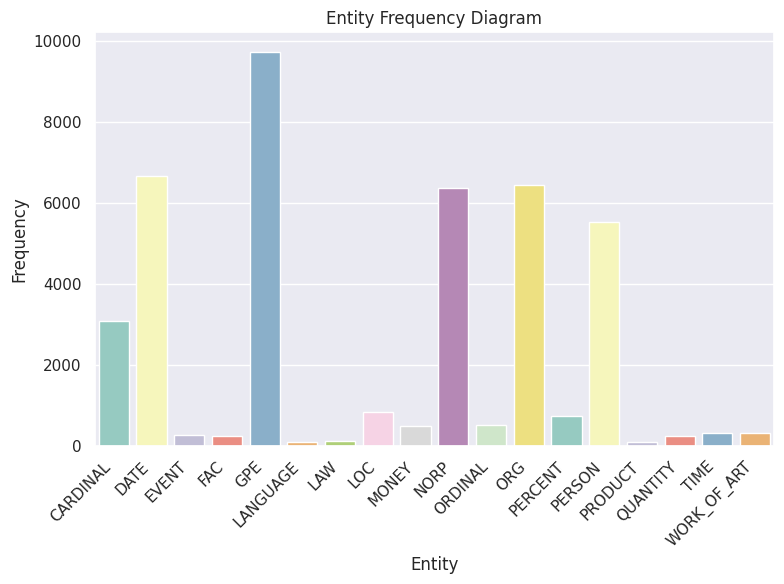

In [17]:
# Filter out rows with 'None' value in the 'entity' column
filtered_tokens_df = tokens_df[tokens_df['entity'].notna()]
filtered_tokens_df = tokens_df[tokens_df['entity'] != '']

# Sort the values in the 'entity' column
#filtered_tokens_df['entity'] = filtered_tokens_df['entity'].astype(str)
#filtered_tokens_df = filtered_tokens_df.sort_values(by='entity')
filtered_tokens_df = filtered_tokens_df.loc[filtered_tokens_df['entity'].astype(str).sort_values().index]

# Create a frequency table
entity_frequency = filtered_tokens_df['entity'].value_counts().reset_index()
entity_frequency.columns = ['entity', 'frequency']

# Create a frequency diagram of unique values in the 'entity' column
plt.figure(figsize=(8, 6))
sns.set(style="darkgrid")
entity_plot = sns.countplot(x="entity", data=filtered_tokens_df, palette="Set3")
entity_plot.set_title("Entity Frequency Diagram")
entity_plot.set_xlabel("Entity")
entity_plot.set_ylabel("Frequency")

# Rotate x-axis labels for better readability (optional)
entity_plot.set_xticklabels(entity_plot.get_xticklabels(), rotation=45, horizontalalignment='right')

# Show the plot
plt.tight_layout()
plt.show()



    CARDINAL - Numerals that do not fall under another type
    DATE - Absolute or relative dates or periods
    EVENT - Named hurricanes, battles, wars, sports events, etc.
    FAC - Buildings, airports, highways, bridges, etc.
    GPE - Countries, cities, states
    LANGUAGE - Any named language
    LAW - Named documents made into laws.
    LOC - Non-GPE locations, mountain ranges, bodies of water
    MONEY - Monetary values, including unit
    NORP - Nationalities or religious or political groups
    ORDINAL - "first", "second", etc.
    PERCENT - Percentage, including "%"
    PERSON - People, including fictional
    PRODUCT - Objects, vehicles, foods, etc. (not services)
    QUANTITY - Measurements, as of weight or distance
    TIME - Times smaller than a day
    WORK_OF_ART - Titles of books, songs, etc.



As we can see there were alot of GPEs, i.e. Countries, cities, states which we say earlier with the prominence of israel and palestine in the dataset. There were also many Dates, NORPs (Nationalities or religious or political groups), ORGs and PERSONs which makes a lot of sense considering the topic. There were almost no products mentioned.

#Topic Modeling
Topic modeling is used for topic discovery and whilst there are various methods for topic modeling, this report will use Latent Dirichlet Allocation (LDA) as it is one of the most popular in this field (Jelodar et al. 2019: 15170).



In [18]:
import gensim
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

# Create a dictionary and corpus
dictionary = Dictionary(clean_corpus)
corp = [dictionary.doc2bow(doc) for doc in clean_corpus]

# Function to train LDA and compute both c_v and UMass coherence scores for a range of topics
def compute_coherence(dictionary, corp, texts, limit, start):
    cv_coherence_values = []
    umass_coherence_values = []
    model_list = []
    for num_topics in range(start, limit+1):
        model = LdaModel(corpus=corp, id2word=dictionary, num_topics=num_topics,iterations=50, passes=10, random_state=5) # random_state makes sure the output is the same each time
        model_list.append(model)
        # c_v coherence
        cv_coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        cv_coherence_values.append(cv_coherencemodel.get_coherence())
        # UMass coherence
        umass_coherencemodel = CoherenceModel(model=model, corpus=corp, dictionary=dictionary, coherence='u_mass')
        umass_coherence_values.append(umass_coherencemodel.get_coherence())

    return model_list, cv_coherence_values, umass_coherence_values


# Set parameters and compute coherence
start, limit = 2, 10
model_list, cv_coherence_values, umass_coherence_values = compute_coherence(dictionary=dictionary, corp=corp, texts=clean_corpus, start=start, limit=limit)


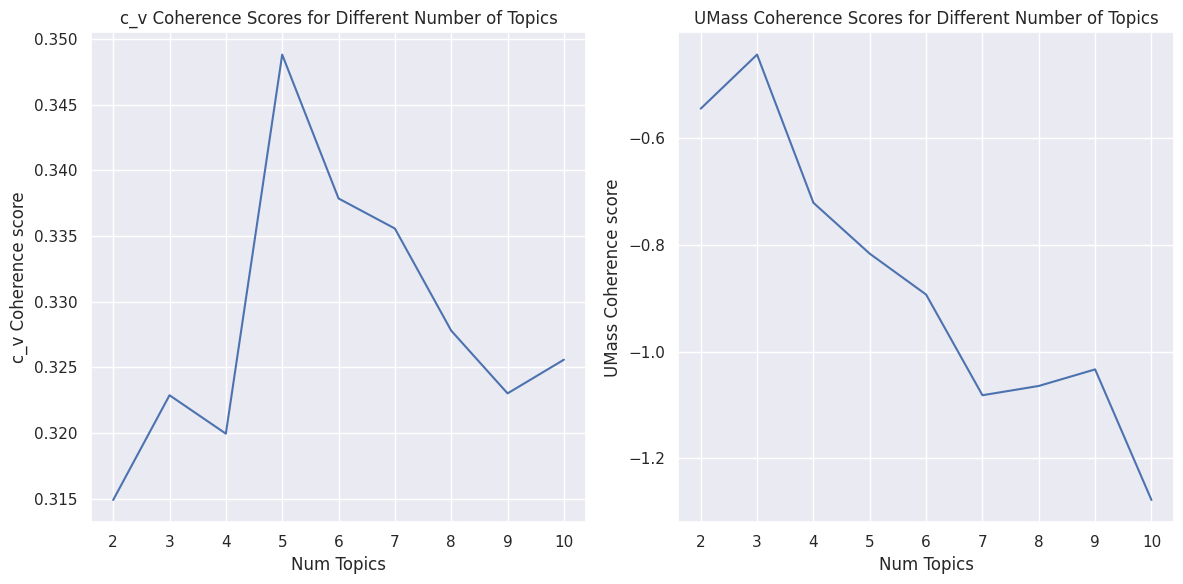

In [19]:
from matplotlib.ticker import MaxNLocator

# Plotting for c_v coherence
x = range(start, limit+1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x, cv_coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("c_v Coherence score")
plt.title("c_v Coherence Scores for Different Number of Topics")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

# Plotting for UMass coherence
plt.subplot(1, 2, 2)
plt.plot(x, umass_coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("UMass Coherence score")
plt.title("UMass Coherence Scores for Different Number of Topics")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

Both graphs show that 5 scores the best on c_V coherence while 3 scores the best on UMass. Since c_V coherence considers the context it is typically seen as a better measure hence this report will use that.

In [ ]:
# Modeling with optimal number of topics (5)
lda_model = model_list[3] #3 corresponds to 5 topics

# Print topics
lda_model.print_topics(-1)


[(0,
  '0.023*"israel" + 0.016*"hamas" + 0.014*"palestinian" + 0.014*"gaza" + 0.012*"israeli" + 0.007*"mr" + 0.007*"war" + 0.005*"would" + 0.004*"say" + 0.004*"one"'),
 (1,
  '0.018*"israel" + 0.015*"palestinian" + 0.012*"israeli" + 0.006*"arab" + 0.005*"hamas" + 0.005*"peace" + 0.005*"one" + 0.005*"gaza" + 0.005*"mr" + 0.004*"state"'),
 (2,
  '0.010*"page" + 0.006*"israel" + 0.004*"israeli" + 0.004*"one" + 0.003*"world" + 0.003*"tunnel" + 0.003*"war" + 0.003*"buy" + 0.003*"amazoncom" + 0.003*"life"'),
 (3,
  '0.020*"israel" + 0.014*"palestinian" + 0.008*"israeli" + 0.006*"arab" + 0.006*"state" + 0.005*"mr" + 0.005*"would" + 0.005*"bank" + 0.004*"country" + 0.004*"west"'),
 (4,
  '0.018*"mr" + 0.016*"israel" + 0.009*"israeli" + 0.008*"palestinian" + 0.008*"would" + 0.007*"netanyahu" + 0.005*"minister" + 0.005*"state" + 0.004*"party" + 0.004*"jewish"')]

#### LDA Results
The terms 'Israel' and 'Palestinian' are frequent topics which is an expected and unsurprising trend.

Topic zero (0) focuses on the Hamas conflict in the Gaza Strip, highlighted by frequent mentions of terms like 'Hamas', 'Gaza', 'war'. These words reflect the militarised and violent nature of the conflict, which has attracted significant attention.

The first topic (1) seems to focus on the general political and state-related aspects of the conflict. 'State' and 'arab' are not surprising due to the ethnic and political nature of the conflict, especially because the conflict revolves around disputes around statehood and territorial rights.

The second topic (2) includes words such as "amazoncom", "buy", and "page". This is probably because of the inclusion of an article where the Economist makes book recommendations which happens to be about Isael and Palestine.

The third topic (3) includes "bank" and "west" whereas the last topic (4) focuses on political leadership within Israel, with a specific reference to 'minister' and 'netanyahu' ( Benjamin Netanyahu, Israeli Prime Minister).


## Sentiment Analysis
A sentiment analysis will be conducted on each article to examine The Economist's portrayal of the Israel-Palestine conflict. Sentiment analysis involves methods and algorithms to identify the sentiment (positive, negative, or neutral) in text (Kedia & Rasu, 2020: 14). Transformers is a library dedicated to supporting transformer-based architectures and facilitates the distribution of pretrained models (Wolf et al. 2019: 1). This report utilises a deep learning based pretrained language model - BERT (Koroteev, 2021: 2). The model was selected for its extensive training on large datasets and effective fine-tuning (Kedia & Rasu, 2020: 278). While initially considering packages like Vader, suitable for shorter social media texts, BERT was ultimately chosen due to its superior performance with longer texts, such as articles.


Besides practical aspects of its training and suitability for extensive text analysis, its selection was also motivated by the consideration of latent content. Within content analysis, there's a significant distinction between manifest and latent content. Initially, content analyses primarily focused on manifest content, which are the elements visibly present and quantifiable (Neuendorf, 2017:  23).  However, an alternative approach includes considering the latent content as well, which encompasses unobserved concepts that, although not directly measurable, can be inferred through various indicators (Neuendorf, 2017:  23).


In the case of the Palestine and Israel conflict, I would argue that it is important access the latent content of the articles as the underlying themes provide more nuance which is particularly needed for such a volatile issue (Neuendorf, 2017:  23). For this reason, this project goes beyond obvious sentiment analysis but tries to capture context and connotation. Hence, adopting models like BERT which are sensitive to nuances in language will allow us to capture the depth of the sentiment expressed within the Economist articles.


### NOTE : Make sure to run the following code on a gpu (go to runtime -> change runtime type), otherwise it will take 4 hours instead of 4 minutes.




We are splitting the longer text (whole article) into sentences for the sentiment analysis. Since long blocks of text such as news articles contain multiple sentiments. Analyzing the article on a sentence-by-sentence basis will help capture these nuances, as different sections may convey different emotions or opinions. We calculate the sentiment of the whole article as the average of the sentiment of the sentences.

In [ ]:
#Using BERT as justified above
import torch
import transformers
from tqdm import tqdm
print(transformers.__version__)
from transformers import pipeline

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # this would take 4 hours on cpu, only takes 4 min on gpu
print(device)

# Load a pre-trained BERT model for sentiment analysis
sentiment_pipeline = pipeline("sentiment-analysis", device=device) #default model is fine
sentiments = []
for article in tqdm(corpus):
    sentences = article.split(".")
    sentiment = 0
    for sent in sentences:
        sent_sent = -1 * sentiment_pipeline(sent)[0]['score']  if sentiment_pipeline(sent)[0]['label'] == 'NEGATIVE' else sentiment_pipeline(sent)[0]['score'] #combines positive and negative sentiments into one score with the negatives being negative numbers
        sentiment += sent_sent
    sentiment /= len(sentences)
    sentiments.append(sentiment)
df["sentiments"] = sentiments
# Now 'sentiments' contains the sentiment analysis results for each article

c:\Users\marcu\.conda\envs\MORLAIF\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4.34.1


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


cuda:0


  0%|          | 0/251 [00:00<?, ?it/s]c:\Users\marcu\.conda\envs\MORLAIF\lib\site-packages\transformers\pipelines\base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 251/251 [02:10<00:00,  1.92it/s]


### Sentiment Distribution

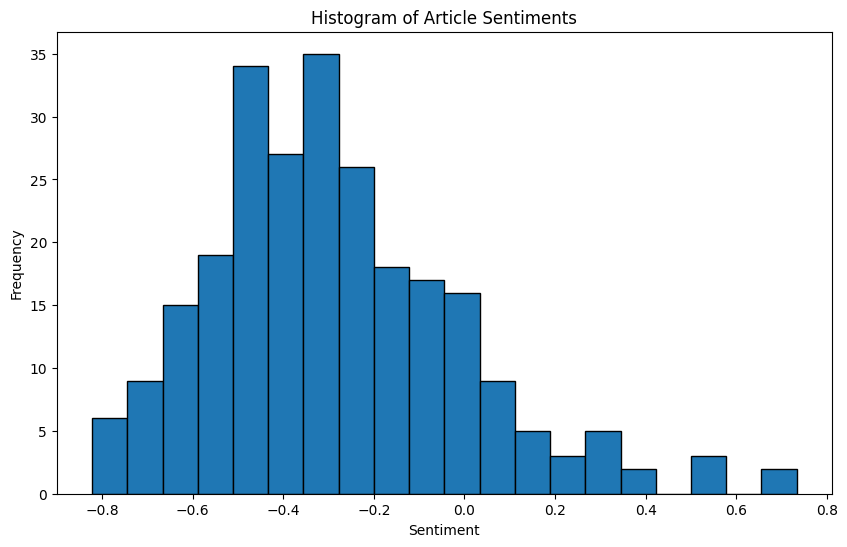

In [ ]:
# Plot sentiments
plt.figure(figsize=(10, 6))
plt.hist(df["sentiments"], bins=20, edgecolor='black')
print("Average sentiment: ", df["sentiments"].mean())
plt.axvline(df["sentiments"].mean(), color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Histogram of Article Sentiments')
plt.show()

The distribution is skewed to the left, indicating that more articles have a negative sentiment than a positive one. The highest bars are around the -0.3 to -0.5 range, suggesting that the most common sentiment scores in these articles are negative.

### Analysing Bias in articles using GPT 4
While BERT is an effective model for sentiment analysis, GPT-4 stands out as another advanced language model which is capable of more complex analysis than just the sentiment. Since I was quite Interested in assessing potential bias in articles concerning the two parties in conflict, I utilized the OpenAI API to direct GPT-4 to evaluate the articles for bias.

### Note : The code will prompt you for an OpenAI API key and will cost about 30 SEK to run.

In [ ]:
from openai import OpenAI
from tqdm import tqdm
def analyze_bias(texts):
    # Prompting you for the API key
    openai_api_key = input("Please enter your OpenAI API key: ")

    client = OpenAI(api_key=openai_api_key)

    results = []
    # For each article we will prompt GPT4 with the following 2 system messages where the first one is the instructions and the second one contains the article text.
    # A new chat is created for each article, GPT doesn't see its previous answers
    for text in tqdm(texts): #progress bar
        response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You will analyse the following text for potential bias. " \
            "Rate the bias of the text on a scale of -5 to 5 with -5 being extremely biased in favor of Palestine, "\
            "5 being extremely biased in favor of Israel and 0 being neutral. Please respond only with an integer."},
            {"role": "system", "content": f"TEXT: {text}"},
        ]
        )
        chat_response = response.choices[0].message.content
        results.append(chat_response)
    return results

texts = df['content'].tolist()
biases = analyze_bias(texts)
biases=[int(bias) for bias in biases]
df['bias'] = biases

100%|██████████| 251/251 [02:56<00:00,  1.42it/s]


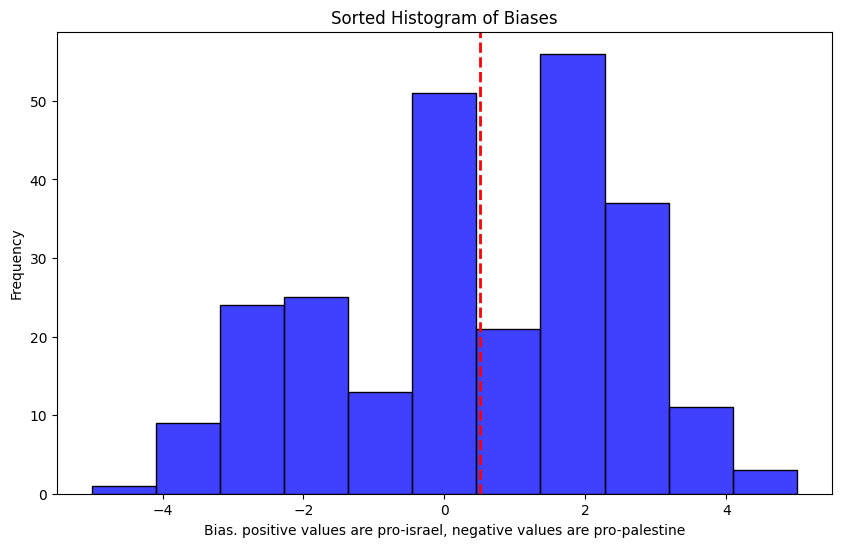

In [3]:
# Visualisation of bias
# Histogram of bias
plt.figure(figsize=(10, 6))
plt.axvline(df["bias"].mean(), color='red', linestyle='dashed', linewidth=2)
sns.histplot(df["bias"], bins=11, color='blue')
plt.title('Sorted Histogram of Biases')
plt.xlabel('Bias. positive values are pro-israel, negative values are pro-palestine')
plt.ylabel('Frequency')
plt.show()

The histogram shows that the data skews slightly towards pro-Israel bias as the mean (red line) appears to be right of the zero center.


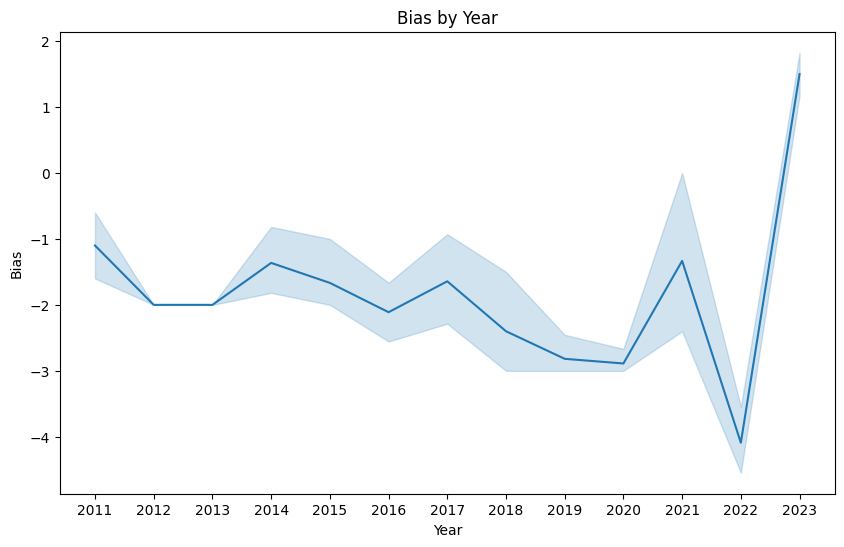

In [ ]:
# Visualisation of bias by year
df = df.sort_values('year')
df2011 = df[df['year'] >='2011']
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='bias', data=df2011)
plt.xlabel('Year')
plt.ylabel('Bias')
plt.title('Bias by Year')
plt.show()

There is a notable spike in pro-Israel bias in 2023, as the line sharply rises from 2022, indicating a significant shift in the tone of the articles towards a more pro-Israel stance.

### Sentiment and Bias by Year

C:\Users\marcu\AppData\Local\Temp\ipykernel_15232\2939247889.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2011["bias"] = df2011["bias"]/5 # rescaling to same scale


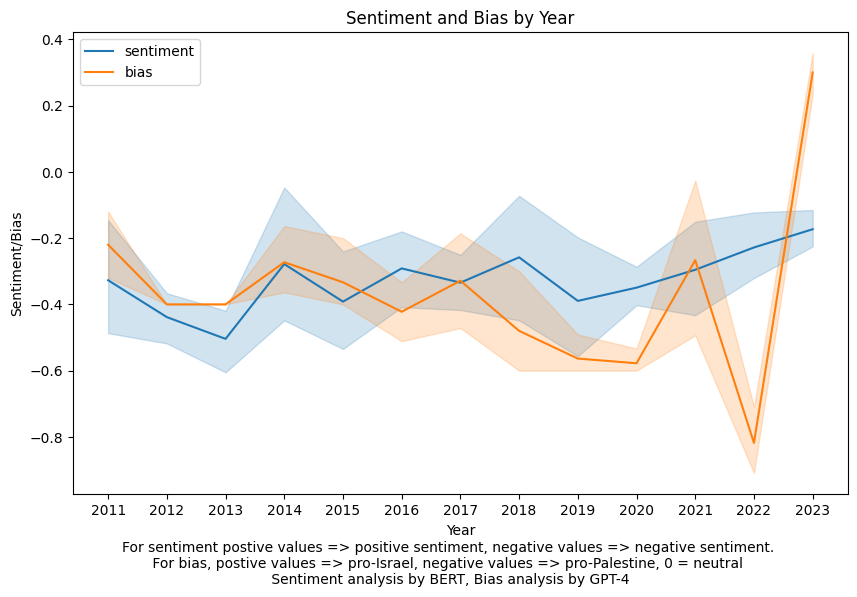

In [ ]:
# plot sentiments by year
df = df.sort_values('year')
df2011 = df[df['year'] >='2011']
plt.figure(figsize=(10, 6))
df2011["bias"] = df2011["bias"]/5 # rescaling to same scale
sns.lineplot(x='year', y='sentiments', data=df2011,label='sentiment')
sns.lineplot(x='year', y='bias', data=df2011,label='bias')
plt.xlabel('Year')
plt.ylabel('Sentiment/Bias')
plt.title('Sentiment and Bias by Year')
plt.figtext(0.5,-0.04,"For sentiment postive values => positive sentiment, negative values => negative sentiment.\n For bias, postive values => pro-Israel, negative values => pro-Palestine, 0 = neutral \n Sentiment analysis by BERT, Bias analysis by GPT-4", ha='center', fontsize=10)
plt.show()

#### Results from the Sentiment and Bias Analysis
The blue line represents the sentiment trend over the years. This line generally hovers between the range of -0.5 to -0.2, indicating a predominantly negative sentiment in the coverage with minor fluctuations over the years.

The orange line depicts the bias trend over the years. The line fluctuates around between the range of -0.8 to -0.2 before 2023, with a sharp rise toward pro-Israel bias in 2023.

While sentiment has remained somewhat consistently negative.

It is somewhat suprising that the sentiment in 2023 is more positive than all other years considering that the october 7th attacks and following war occoured in 2023.

The sentiment and bias analysis of articles from The Economist reveals significant insights, including a predominantly negative sentiment trend and a sharp rise towards a pro-Israel bias in 2023. This study highlights the importance of such analyses in understanding media influence through news articles, promoting journalistic accountability and transparency which can have serious implications especially in shaping public opinion on such controversial topics. The dramatic change in bias towards a pro-Israel stance urges the need for further investigation to discern the causes behind these shifts, to discern whether these trends are reflective of broader media patterns as these could have serious repercussions.



#### Limitations
This lab report acknowledges that it is important to consider how the sentiment analysis by BERT and the bias analysis by GPT-4 may differ and these methodological differences might be influencing the outcome of the analysis.

The reasoning of GPT-4 when assigning bias ratings is rather opaque and since it has not specifically been trained (that I know of) to produce unbiased judgements of the bias of text, we cannot be sure that it is not itself biased. We also do not know if the reasoning would be consistent since I only ran it once, it could be the case that it provides different answers different times it is run.

Looking at the distribution in the histogram figure above (sorted histogram of biases), it seems like a normal distribution. Except for the fact that the ratings -1 and 1 are strangely low. It seems unlikely that fewer articles would have these specific levels of bias, so it could be the case that GPT-4 does not like outputting the number 1 for other reasons. Hence, it is important to remain cognisant of such flaws within the model.


Lastly, it is important to acknowledge that the scope of this analysis is constrained by a limited sample size, which inherently limits its generalizability. The findings derived should not be extrapolated as representative of all journalistic content produced by The Economist, nor should they be considered indicative of trends prevalent in other news publications. Therefore, to gain a more comprehensive understanding, it would be better to conduct further research using a more extensive dataset.



### References

Al-Sarraj, W.F. and Lubbad, H.M. (2018) ‘Bias Detection of Palestinian/Israeli Conflict in Western Media: A Sentiment Analysis Experimental Study’, in 2018 International Conference on Promising Electronic Technologies (ICPET). 2018 International Conference on Promising Electronic Technologies (ICPET), pp. 98–103. Available at: https://doi.org/10.1109/ICPET.2018.00024.

Gelvin, J.L. (2014) The Israel-Palestine Conflict: One Hundred Years of War. Cambridge University Press.


Imtiaz, A. et al. (2022) ‘Taking sides: Public Opinion over the Israel-Palestine Conflict in 2021’. arXiv. Available at: https://doi.org/10.48550/arXiv.2201.05961.


Jelodar, H. et al. (2019) ‘Latent Dirichlet allocation (LDA) and topic modeling: models, applications, a survey’, Multimedia Tools and Applications, 78(11), pp. 15169–15211. Available at: https://doi.org/10.1007/s11042-018-6894-4.


Kedia, A. & Rasu, M. (2020) Hands-On Python Natural Explore tools and techniques to analyze and process text with. Packt Publishing, Ltd.


Koroteev, M.V. (2021) ‘BERT: A Review of Applications in Natural Language Processing and Understanding’. arXiv. Available at: https://doi.org/10.48550/arXiv.2103.11943.


Neuendorf, K. A. (2017) The Content Analysis Guidebook. Thousand Oaks, California: SAGE Publications. doi: 10.5260/chara.19.4.38.


Wolf, T. et al. (2020) ‘HuggingFace’s Transformers: State-of-the-art Natural Language Processing’. arXiv. Available at: https://doi.org/10.48550/arXiv.1910.03771.
